<a href="https://colab.research.google.com/github/falseywinchnet/PyITD/blob/main/m_layer_spiral_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# M-Layer Spiral Classification (PyTorch)

Replicating **Figure 2** from:
> Fischbacher et al., "Intelligent Matrix Exponentiation", [arXiv:2008.03936](https://arxiv.org/abs/2008.03936)

Original github repo: [google-research/m-layer](https://github.com/google-research/google-research/tree/master/m_layer)

This demonstrates the M-layer's ability to **extrapolate** on spiral data, compared to standard DNNs.

In [2]:
import torch
import torch. nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch. cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 1. M-Layer Implementation

In [3]:
class MLayer(nn.Module):
    """M-Layer: Maps input to matrices via generators, then applies matrix exp.

    Given input x of shape (..., dim_in):
      1. M = sum_a x[a] * G[a] + bias   (linear combo of generator matrices)
      2. Return expm(M)
    """

    def __init__(self, dim_in, dim_m, with_bias=False, use_approx=False, num_squarings=6):
        super().__init__()
        self.dim_m = dim_m
        self.with_bias = with_bias
        self.use_approx = use_approx
        self.num_squarings = num_squarings

        # Generator matrices:  (dim_in, dim_m, dim_m)
        self.generators = nn.Parameter(torch.randn(dim_in, dim_m, dim_m) * 0.1)

        if with_bias:
            self.bias = nn.Parameter(torch. randn(1, dim_m, dim_m) * 0.1)
        else:
            self.register_parameter('bias', None)

    def forward(self, x):
        # x:  (..., dim_in) -> M:  (..., dim_m, dim_m)
        M = torch.einsum('... a, amn -> ...mn', x, self. generators)

        if self.with_bias:
            M = M + self.bias

        if self.use_approx:
            # Approximation:  (I + M/2^k)^(2^k)
            mat = M / (2 ** self.num_squarings) + torch.eye(self. dim_m, device=x.device)
            for _ in range(self.num_squarings):
                mat = mat @ mat
            return mat
        else:
            return torch.linalg.matrix_exp(M)

## 2. Generate Spiral Data

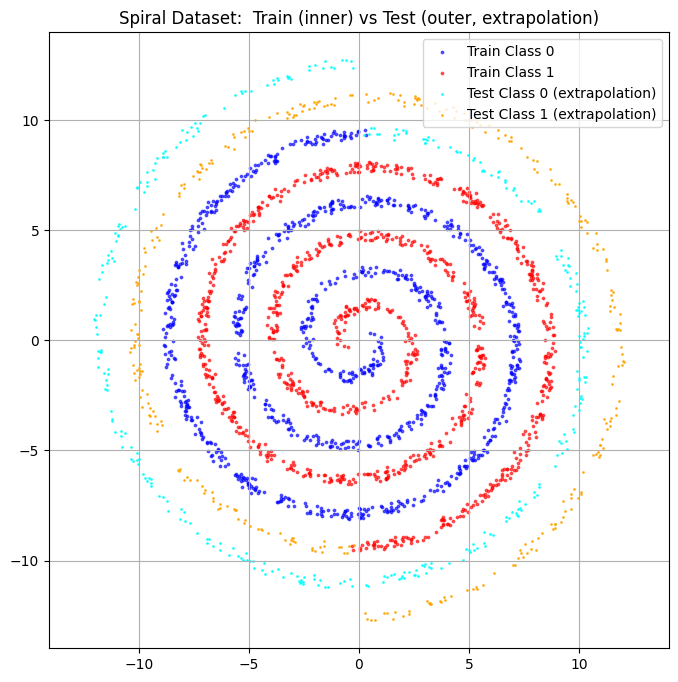

In [4]:
def generate_spiral(n_points, noise=0.5, rng=None, extra_rotation=False):
    """Generate two interleaved spirals.

    Args:
        n_points: Number of points per class
        noise: Amount of noise to add
        rng: Random state
        extra_rotation:  If True, generate points further out (for extrapolation test)

    Returns:
        X: (2*n_points, 2) coordinates
        y: (2*n_points,) labels (0 or 1)
    """
    if rng is None:
        rng = np.random.RandomState()

    if not extra_rotation:
        # Training data:  inner part of spiral
        n = np.sqrt(0.001 + 0.25 * rng.rand(n_points, 1)) * 6 * (2 * np.pi)
    else:
        # Test data: outer part of spiral (extrapolation)
        n = np.sqrt((7.0/36) * rng.rand(n_points, 1) + 0.25) * 6 * (2 * np.pi)

    x = 0.5 * (np.sin(n) * n + (2 * rng.rand(n_points, 1) - 1) * noise)
    y = 0.5 * (np.cos(n) * n + (2 * rng. rand(n_points, 1) - 1) * noise)

    # Class 0: (x, y), Class 1: (-x, -y)
    X = np.vstack([np.hstack([x, y]), np.hstack([-x, -y])])
    labels = np.hstack([np.zeros(n_points), np.ones(n_points)])

    return X. astype(np.float32), labels.astype(np.float32)

# Generate data
X_train, y_train = generate_spiral(1000, rng=np.random.RandomState(1))
X_test, y_test = generate_spiral(333, extra_rotation=True, rng=np. random.RandomState(2))

# Visualize
plt.figure(figsize=(8, 8))
plt.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], c='blue', s=3, alpha=0.6, label='Train Class 0')
plt.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], c='red', s=3, alpha=0.6, label='Train Class 1')
plt.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], c='cyan', s=1, alpha=0.8, label='Test Class 0 (extrapolation)')
plt.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], c='orange', s=1, alpha=0.8, label='Test Class 1 (extrapolation)')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.title('Spiral Dataset:  Train (inner) vs Test (outer, extrapolation)')
plt.show()

## 3. Define Models

In [185]:
# Hyperparameters (matching the paper)
DIM_REP = 10       # Intermediate representation dimension
DIM_MATRIX = 10    # M-layer matrix size
LAYER_SIZE = 35    # DNN hidden layer size (Increased for comparable parameters)
LR = 0.01
EPOCHS = 500
BATCH_SIZE = 16

class MLayer(nn.Module):
    """M-Layer: Maps input to matrices via generators, then applies matrix exp.

    Given input x of shape (..., dim_in):
      1. M = sum_a x[a] * G[a] + bias   (linear combo of generator matrices)
      2. Return expm(M)
    """

    def __init__(self, dim_in, dim_m, with_bias=False, use_approx=False, num_squarings=6):
        super().__init__()
        self.dim_m = dim_m
        self.with_bias = with_bias
        self.use_approx = use_approx
        self.num_squarings = num_squarings

        # Generator matrices:  (dim_in, dim_m, dim_m)
        self.generators = nn.Parameter(torch.randn(dim_in, dim_m, dim_m) * 0.1)

        if with_bias:
            self.bias = nn.Parameter(torch. randn(1, dim_m, dim_m) * 0.1)
        else:
            self.register_parameter('bias', None)

    def forward(self, x):
        # x:  (..., dim_in) -> M:  (..., dim_m, dim_m)
        M = torch.einsum('... a, amn -> ...mn', x, self. generators)

        if self.with_bias:
            M = M + self.bias

        if self.use_approx:
            # Approximation:  (I + M/2^k)^(2^k)
            mat = M / (2 ** self.num_squarings) + torch.eye(self. dim_m, device=x.device)
            for _ in range(self.num_squarings):
                mat = mat @ mat
            return mat
        else:
            return torch.linalg.matrix_exp(M)

class MLayerModel(nn.Module):
    """M-Layer based classifier."""
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, DIM_REP),            # (2,) -> (DIM_REP,)
            MLayer(DIM_REP, DIM_MATRIX, with_bias=True),  # -> (DIM_MATRIX, DIM_MATRIX)
            nn.Flatten(),                      # -> (DIM_MATRIX^2,)
            nn.Linear(DIM_MATRIX * DIM_MATRIX, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x).squeeze(-1)

import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class LieMLayer(nn.Module):
    def __init__(self, input_dim, dim_m, config=None):
        super().__init__()
        # 1. Structure
        # We model the algebra as a direct sum of so(2) subalgebras (2x2 rotations).
        # This requires dim_m to be even.
        assert dim_m % 2 == 0, "LieMLayer requires even matrix dimension for block pairing."
        self.n = dim_m
        self.n_blocks = dim_m // 2

        # 2. The Basis (The "Frame")
        # We learn a static basis P. To ensure P is well-conditioned (ideally orthogonal),
        # we initialize it as random orthogonal.
        # Direction Four: "diagonalize once in a learned frame"
        self.frame = nn.Parameter(torch.empty(self.n, self.n))
        nn.init.orthogonal_(self.frame)

        # 3. The Generators (The "Angles")
        # Instead of generating an N*N matrix, we generate N/2 rotation angles.
        # This reduces the generator mapping from O(D*N^2) to O(D*N).
        # Direction One: "complexity collapses"

        # Internal embedding dimension for the generator manifold
        self.d = 8

        self.u = nn.Linear(input_dim, self.d)
        self.generator_theta = nn.Linear(self.d, self.n_blocks)
        self.u2 = nn.Linear(input_dim, self.d)
        self.generator_theta2 = nn.Linear(self.d, self.n_blocks)
        # 4. Readout

    def forward(self, x):
        batch_size = x.shape[0]

        # 1. Norm & Embed
        # Peer Note: "scaling of x" is handled naturally by angle linearity
        x = F.rms_norm(x, (x.size(-1),))
        latent = self.u(x)

        # 2. Predict Angles
        # theta shape: (Batch, n_blocks)
        theta = self.generator_theta(latent)
        latent2 = self.u2(x)

        # 2. Predict Angles
        # theta shape: (Batch, n_blocks)
        theta2 = self.generator_theta2(latent2)
        # 3. Analytic Exponentiation (Direction One: "exp reduces to many tiny expm calls")
        # We compute the rotation blocks analytically using Euler's formula.
        # [ cos t  sin t ]
        # [ -sin t cos t ]

        c = torch.cos(theta) # (Batch, n_blocks)
        s = torch.sin(theta2) # (Batch, n_blocks)

        # Construct the Block Diagonal Matrix R
        # This is the "Exponentiated M" in the diagonal frame
        # We construct it sparsely or via tensor formatting to stay fast.

        # We build the diagonal and off-diagonal parts
        # Pytorch representation: We want a (B, N, N) matrix.
        # This part is slightly overhead-heavy in Python, but math-light.

        R = torch.zeros(batch_size, self.n, self.n, device=x.device, dtype=x.dtype)

        # Fill (2i, 2i) and (2i+1, 2i+1) with cos
        # Fill (2i, 2i+1) with sin
        # Fill (2i+1, 2i) with -sin

        # We use strided indexing for speed
        # Indices for 2x2 blocks
        indices = torch.arange(self.n_blocks, device=x.device)
        idx_even = 2 * indices
        idx_odd = 2 * indices + 1

        # Cosines on diagonal
        R[:, idx_even, idx_even] = c
        R[:, idx_odd, idx_odd] = c

        # Sines on off-diagonal
        R[:, idx_even, idx_odd] = s
        R[:, idx_odd, idx_even] = -s

        # 4. Basis Transform (Direction Four: "Diagonalize in a learned frame")
        # Output = P * R * P^T
        # We apply the learned frame to mix the rotations back into the ambient space

        # (N, N) @ (B, N, N) -> (B, N, N)
        P = self.frame
        M_out = torch.matmul(P, torch.matmul(R, P.t()))

        # 5. Readout
        # Flatten and project
        return M_out

class LELU(nn.Module):
    def __init__(self):
        super().__init__()
        self.scale = math.pi / math.sqrt(3.0)

    def forward(self, x):
        return x * torch.sigmoid(self.scale * x)

class ParallelSum(nn.Module):
    """Passes input to multiple modules and sums their outputs."""
    def __init__(self, *modules):
        super().__init__()
        self.stages = nn.ModuleList(modules)
        self.act = LELU()

    def forward(self, x):
        return sum(stage(x) for stage in self.stages)

class FastMLayerModel(nn.Module):
    """Better M-Layer based classifier."""
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, DIM_REP),
            LieMLayer(DIM_REP, DIM_MATRIX),
            nn.Flatten(),                      # -> (DIM_MATRIX^2,)
            LELU(),
            nn.Linear(DIM_MATRIX * DIM_MATRIX, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.net(x)
        return x.squeeze(-1)

print("M-Layer Model:")
print(MLayerModel())
print(f"\nParameters: {sum(p.numel() for p in MLayerModel().parameters())}")

print("Single-Frame LieMLayer Model:")
print(FastMLayerModel())
print(f"Parameters: {sum(p.numel() for p in FastMLayerModel().parameters())}")


M-Layer Model:
MLayerModel(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): MLayer()
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=100, out_features=1, bias=True)
    (4): Sigmoid()
  )
)

Parameters: 1231
Single-Frame LieMLayer Model:
FastMLayerModel(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): LieMLayer(
      (u): Linear(in_features=10, out_features=8, bias=True)
      (generator_theta): Linear(in_features=8, out_features=5, bias=True)
      (u2): Linear(in_features=10, out_features=8, bias=True)
      (generator_theta2): Linear(in_features=8, out_features=5, bias=True)
    )
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): LELU()
    (4): Linear(in_features=100, out_features=1, bias=True)
    (5): Sigmoid()
  )
)
Parameters: 497


## 4. Training Loop

In [103]:
def train_model(model, X_train, y_train, epochs=EPOCHS, lr=LR, batch_size=BATCH_SIZE, patience=150, verbose=True):
    """Train a model with early stopping."""
    model = model.to(device)
    X = torch.tensor(X_train).to(device)
    y = torch.tensor(y_train).to(device)

    optimizer = optim.RMSprop(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.2, min_lr=1e-5)
    criterion = nn.BCELoss()

    losses = []
    best_loss = float('inf')
    patience_counter = 0
    best_state = None

    n_samples = len(X)

    for epoch in range(epochs):
        model.train()

        # Shuffle
        perm = torch.randperm(n_samples)
        X_shuffled = X[perm]
        y_shuffled = y[perm]

        epoch_loss = 0
        n_batches = 0

        for i in range(0, n_samples, batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss. backward()
            optimizer.step()

            epoch_loss += loss.item()
            n_batches += 1

        avg_loss = epoch_loss / n_batches
        losses. append(avg_loss)
        scheduler.step(avg_loss)

        # Early stopping
        if avg_loss < best_loss - 0.0001:
            best_loss = avg_loss
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            if verbose:
                print(f"Early stopping at epoch {epoch+1}")
            break

        if verbose and (epoch + 1) % 100 == 0:
            acc = ((model(X) > 0.5).float() == y).float().mean().item()
            print(f"Epoch {epoch+1}:  Loss = {avg_loss:.4f}, Acc = {acc:.4f}")

    # Restore best weights
    if best_state is not None:
        model. load_state_dict(best_state)
        model = model.to(device)

    return model, losses

## 5. Visualization Function (Decision Boundary)

In [10]:
def plot_decision_boundary(model, X_train, y_train, X_test, y_test, title="", ax=None):
    """Plot decision boundary with training and test points."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))

    model.eval()

    # Create grid for decision boundary
    delta = 0.125  # Grid resolution
    x_range = np.arange(-14, 14.01, delta)
    y_range = np. arange(-14, 14.01, delta)
    XX, YY = np.meshgrid(x_range, y_range)

    grid_points = np.column_stack([XX. ravel(), YY.ravel()]).astype(np.float32)
    grid_tensor = torch.tensor(grid_points).to(device)

    with torch.no_grad():
        Z = model(grid_tensor).cpu().numpy()
    Z = Z.reshape(XX.shape)

    # Plot decision regions
    ax.contourf(XX, YY, Z, levels=[0.0, 0.5, 1.0],
                colors=[(0.41, 0.67, 0.81, 0.3), (0.89, 0.51, 0.41, 0.3)])

    # Plot decision boundary
    ax. contour(XX, YY, Z, levels=[0.5], colors='black', linewidths=1.5)

    # Plot training points
    ax.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1],
               c='#4A90D9', s=4, alpha=0.7, label='Train Class 0')
    ax.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1],
               c='#D96459', s=4, alpha=0.7, label='Train Class 1')

    # Plot test points (extrapolation region)
    ax.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1],
               c='#4A90D9', s=1, alpha=0.9, marker='.')
    ax.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1],
               c='#D96459', s=1, alpha=0.9, marker='.')

    ax. set_xlim(-14, 14)
    ax. set_ylim(-14, 14)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax. set_title(title, fontsize=14)

    return ax

## 6. Train and Compare Models (Figure 2)

In [181]:
# Train M-Layer model
print("="*50)
print("Training M-Layer Model")
print("="*50)
torch.manual_seed(42)
m_layer_model = MLayerModel()
m_layer_model, m_layer_losses = train_model(m_layer_model, X_train, y_train)

Training M-Layer Model
Epoch 100:  Loss = 0.0000, Acc = 1.0000
Early stopping at epoch 195


In [186]:
# Train M-Layer model
print("="*50)
print("Training Fast M-Layer Model")
print("="*50)
torch.manual_seed(42)
fm_layer_model = FastMLayerModel()
fm_layer_model, fm_layer_losses = train_model(fm_layer_model, X_train, y_train)

Training Fast M-Layer Model
Epoch 100:  Loss = 0.0004, Acc = 1.0000
Epoch 200:  Loss = 0.0000, Acc = 1.0000
Early stopping at epoch 282


In [187]:
# Evaluate on test set (extrapolation)
def evaluate(model, X, y):
    model.eval()
    X_t = torch.tensor(X).to(device)
    y_t = torch.tensor(y).to(device)
    with torch.no_grad():
        preds = model(X_t)
        acc = ((preds > 0.5).float() == y_t).float().mean().item()
    return acc

print("\n" + "="*50)
print("RESULTS")
print("="*50)
print(f"{'Model':<20} {'Train Acc':<12} {'Test Acc (Extrapolation)'}")
print("-"*50)
print(f"{'M-Layer':<20} {evaluate(m_layer_model, X_train, y_train):.4f}       {evaluate(m_layer_model, X_test, y_test):.4f}")
print(f"{'Fast M-Layer':<20} {evaluate(fm_layer_model, X_train, y_train):.4f}       {evaluate(fm_layer_model, X_test, y_test):.4f}")



RESULTS
Model                Train Acc    Test Acc (Extrapolation)
--------------------------------------------------
M-Layer              1.0000       0.8754
Fast M-Layer         1.0000       0.2793


## 7. Plot Figure 2: Decision Boundaries Comparison

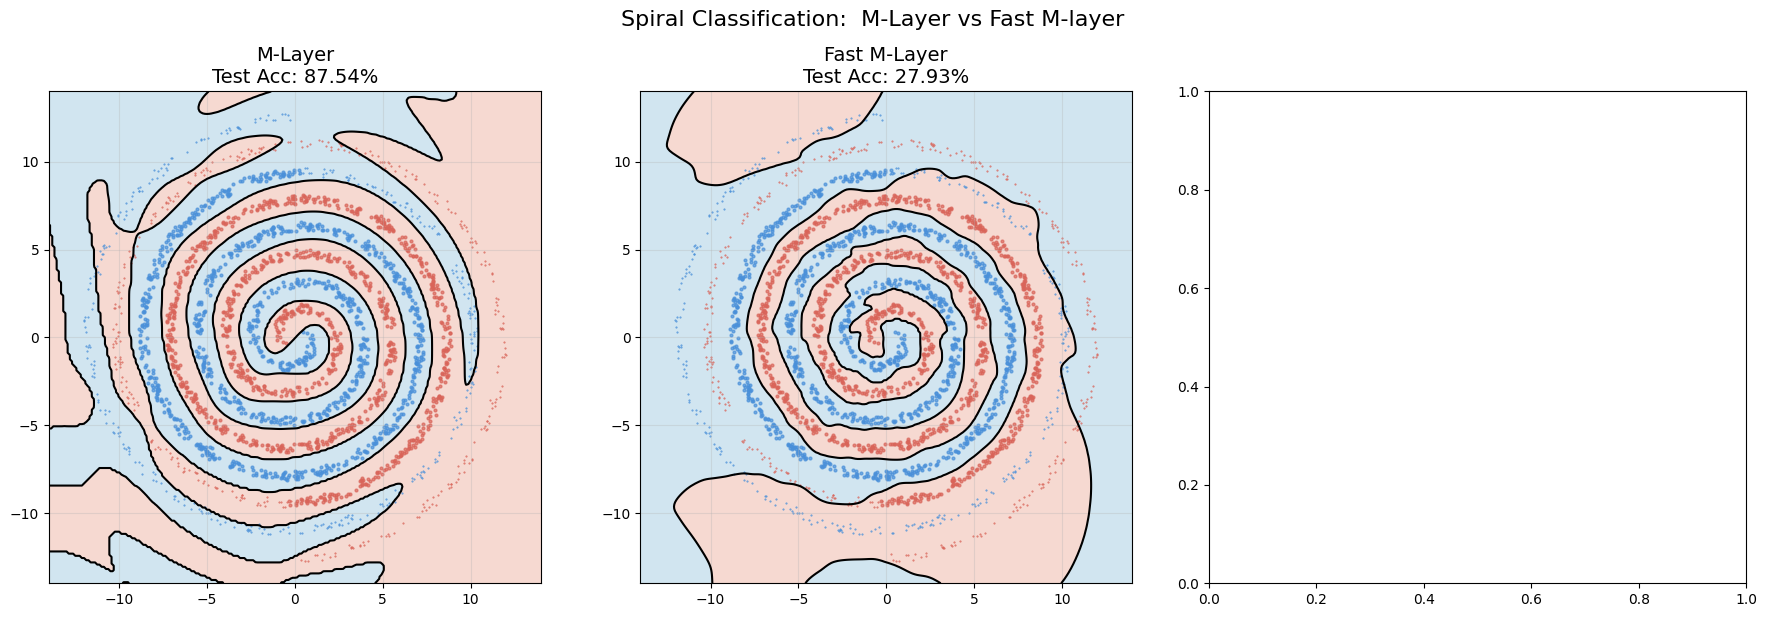

In [188]:
fig, axes = plt. subplots(1, 3, figsize=(18, 6))

plot_decision_boundary(m_layer_model, X_train, y_train, X_test, y_test,
                       title=f"M-Layer\nTest Acc: {evaluate(m_layer_model, X_test, y_test):.2%}",
                       ax=axes[0])

plot_decision_boundary(fm_layer_model, X_train, y_train, X_test, y_test,
                       title=f"Fast M-Layer\nTest Acc: {evaluate(fm_layer_model, X_test, y_test):.2%}",
                       ax=axes[1])


plt. suptitle('Spiral Classification:  M-Layer vs Fast M-layer', fontsize=16, y=1.02)
plt.tight_layout()
plt. savefig('figure2_spiral_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Training Loss Comparison

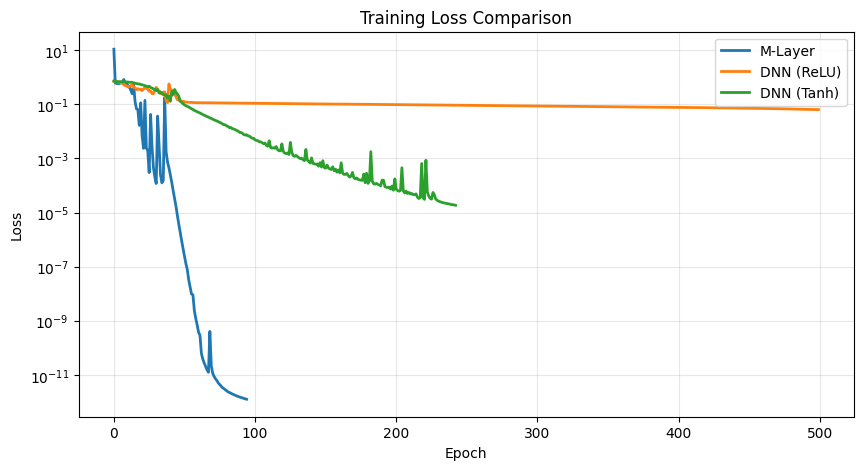

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(m_layer_losses, label='M-Layer', linewidth=2)
plt. plot(dnn_relu_losses, label='DNN (ReLU)', linewidth=2)
plt. plot(dnn_tanh_losses, label='DNN (Tanh)', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt. yscale('log')
plt.grid(True, alpha=0.3)
plt. show()

## 9. Key Observations

**From Figure 2 (replicating the paper):**

1. **M-Layer extrapolates well**: The decision boundary continues the spiral pattern into the outer region (test data), correctly classifying extrapolation points.

2. **DNN (ReLU) fails to extrapolate**:  The decision boundary becomes piecewise linear and does not follow the spiral structure outside the training region.

3. **DNN (Tanh) also struggles**: While smoother than ReLU, it still fails to capture the rotational/periodic structure needed for extrapolation.

**Why M-Layer works:**
- The matrix exponential naturally produces **rotation-like** transformations
- It learns the underlying **Lie group structure** of the spiral
- Extrapolation = continuing the learned rotation, which exp(M) does naturally

## 10. Bonus: Visualize Learned Generator Matrices

Generator shape: (10, 10, 10)


/tmp/ipython-input-3089337650.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


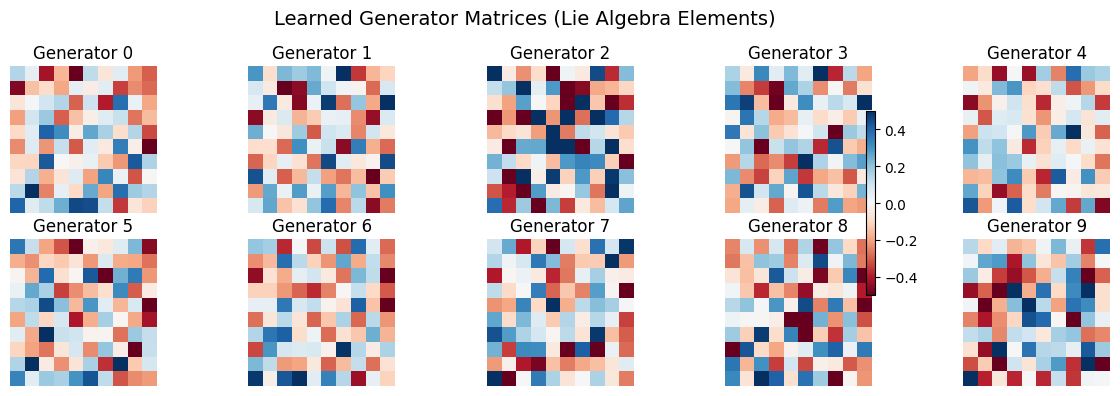

In [ ]:
# Extract the M-Layer from the model
m_layer = m_layer_model.net[1]

generators = m_layer.generators. detach().cpu().numpy()
print(f"Generator shape: {generators.shape}")

# Plot first few generators
fig, axes = plt.subplots(2, 5, figsize=(12, 4))
for i, ax in enumerate(axes. flat):
    if i < generators.shape[0]:
        im = ax.imshow(generators[i], cmap='RdBu', vmin=-0.5, vmax=0.5)
        ax.set_title(f'Generator {i}')
        ax.axis('off')

plt.colorbar(im, ax=axes, shrink=0.6)
plt.suptitle('Learned Generator Matrices (Lie Algebra Elements)', fontsize=14)
plt.tight_layout()
plt.show()